# Extrapolation Detection (4.3)
Ant Ngo

In [129]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from pycebox.ice import ice, ice_plot
from matplotlib.cm import seismic

**Model distribution:**

$Y = 10X^{2}_{1} + \mathbb{1}_{X_{2} \geq 0} + \varepsilon$,

$\varepsilon \overset{\text{iid}}{\sim} \mathcal{N}(0, .1^{2}), \begin{bmatrix}
X_1\\
X_2
\end{bmatrix}
\sim \begin{cases}
U(-1,0), U(-1,0) &\text{w.p. $\frac{1}{3}$}\\
U(0,1), U(-1,0) &\text{w.p. $\frac{1}{3}$}\\
U(-1,0), U(0,1) &\text{w.p. $\frac{1}{3}$}\\
U(0,1), U(0,1) &\text{w.p. $0$}\\
\end{cases}$

In [90]:
def extrap_ex_sim(N, seed = None):
    '''
    #' Generates simulated data in 
    #' Section 4.3 Extrapolation Detection
    #' @param N Number of samples to generate.
    #' @param seednum Random seed for reproducibility.
    #' @return Simulated data (dataframe) with N observations.
    #' @examples
    #' extrap_ex_sim(1000,1)
    #' extrap_ex_sim(3000,420)
    '''
    # force seed if not defined
    if seed is None:
        np.random.seed(seed)
    
    def simulate():
        '''
        #' Helper to simulate one observation
        #' @return Single randomly generated observation
        #' based on 4.3 distribution.
        '''

        # generate random probability (0-1)
        s = np.random.uniform(low = 0, high = 1)

        # get distribution for x1, x2
        if s < (1/3):
            x1 = np.random.uniform(low = -1, high = 0, size = 1)
            x2 = np.random.uniform(low = -1, high = 0, size = 1)
        else:
            if s < (2/3):
                x1 = np.random.uniform(low = -1, high = 0, size = 1)
                x2 = np.random.uniform(low = 0, high = 1, size = 1)
            else:
                x1 = np.random.uniform(low = 0, high = 1, size = 1)
                x2 = np.random.uniform(low = -1, high = 0, size = 1)

        # generate single observation
        single_obs = np.concatenate((x1,x2), axis = 0)

        return single_obs
 
    
    # set distribution params
    b1, b2, sd = 10, 1, 0.1
    
    # matrix initialization
    X = np.full([N, 2], None)
    
    # simulate feature matrix
    for i in range(0,N):
        X[i,] = simulate()
        
    # create epsilon (noise)
    noise = sp.stats.norm.rvs(size=N)
    
    # generate Y
    y = b1 * (X[:,0]**2) + b2 *(X[:,1]>0) + noise
    y = y.reshape(-1,1)
    
    # concat feature matrix and target vector
    df = np.concatenate([X,y], axis = 1)
    
    # convert to df
    df = pd.DataFrame(df, columns = ['x1','x2','y'])
    
    return df

In [91]:
df = extrap_ex_sim(1000)
df.head()

,x1,x2,y
0,0.382194,-0.562463,2.37571
1,-0.605154,-0.817572,4.52097
2,-0.0225837,-0.126493,0.638852
3,-0.251696,-0.270005,1.05247
4,-0.342893,0.099568,2.32401


In [109]:
df = df[['x1','x2']]
b1, b2, sd = 10, 1, 0.1
noise = sp.stats.norm.rvs(size=1000)
y = b1 * (df.x1**2) + b2 * (df.x2 > 0) + noise


In [110]:
rf = RandomForestRegressor(n_estimators = 500)
rf.fit(df.values, y)

RandomForestRegressor(n_estimators=500)

# ICE Plots

In [116]:
ice_df = ice(df, 'x1', rf.predict, num_grid_points=100)

In [117]:
ice_df.head()

data_x1,-0.999667,-0.999399,-0.997256,-0.995833,-0.995081,-0.995030,-0.994982,-0.993952,-0.992832,-0.990314,...,0.968923,0.973956,0.976435,0.981906,0.983035,0.988838,0.990030,0.990726,0.991376,0.993815
x2,0.255686,-0.391390,-0.547275,-0.998172,-0.598581,0.476618,-0.408281,0.618561,-0.271539,0.322632,...,-0.264822,-0.930441,-0.621632,-0.289068,-0.174462,-0.831284,-0.943437,-0.173310,-0.915073,-0.328703
x1,,,,,,,,,,,,,,,,,,,,,
-0.999667,11.427797,10.915326,9.472035,9.936160,9.313065,11.933658,10.911834,11.147797,10.652250,11.465567,...,10.649952,9.377716,9.313519,10.652250,10.664577,9.332822,9.509402,10.664577,9.387375,10.665344
-0.989322,11.432723,10.023306,8.883923,9.373562,8.653020,11.831298,10.059495,10.976601,9.729623,11.486709,...,9.703202,8.647995,8.655777,9.727060,9.752869,8.581713,8.843321,9.752869,8.659552,9.777241
-0.971471,10.760482,9.646640,9.082240,9.585021,8.978214,11.217167,9.710638,10.751673,9.434484,10.864690,...,9.425303,9.038788,8.983273,9.434982,9.296598,9.043691,9.172036,9.296598,9.056947,9.469531
-0.959538,10.835422,9.624430,8.974383,9.486258,8.916107,11.115455,9.649170,10.702638,9.514683,10.826454,...,9.514683,8.956832,8.918779,9.516544,9.510681,9.011947,9.024415,9.510681,8.970955,9.543754
-0.938670,9.531133,8.256668,8.221457,9.098955,8.278693,9.285853,8.250047,9.386740,8.162283,9.414245,...,8.160305,8.226953,8.279949,8.162157,8.453887,8.313156,8.261074,8.453887,8.240266,8.154641


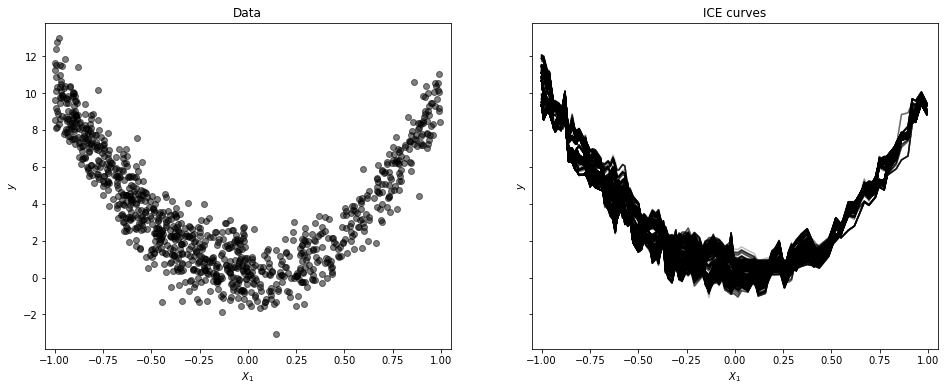

In [118]:
fig, (data_ax, ice_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16, 6))

data_ax.scatter(df.x1, y, c='k', alpha=0.5);

data_ax.set_xlim(-1.05, 1.05);
data_ax.set_xlabel('$X_1$');

data_ax.set_ylabel('$y$');

data_ax.set_title('Data');

ice_plot(ice_df, frac_to_plot=1,
         c='k', alpha=0.25,
         ax=ice_ax);

ice_ax.set_xlabel('$X_1$');

ice_ax.set_ylabel('$y$');

ice_ax.set_title('ICE curves');

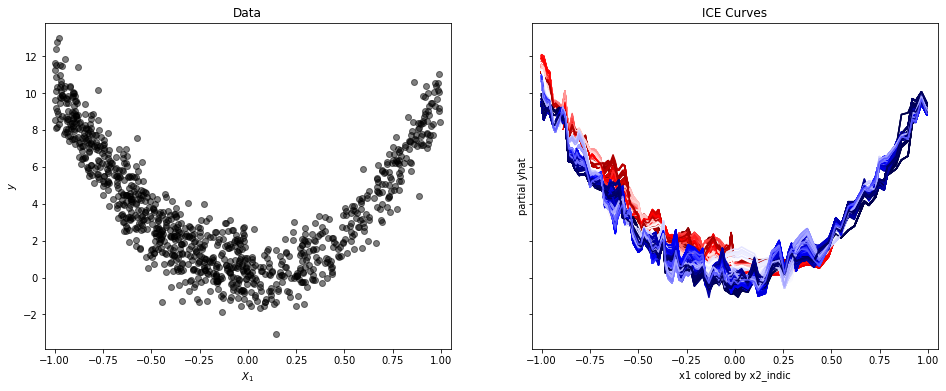

In [134]:
fig, (data_ax, ice_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16, 6))

data_ax.scatter(df.x1, y, c='k', alpha=0.5);

data_ax.set_xlim(-1.05, 1.05);
data_ax.set_xlabel('$X_1$');

data_ax.set_ylabel('$y$');

data_ax.set_title('Data');

ice_plot(ice_df, frac_to_plot=1,
         color_by='x2', cmap=seismic,
         ax=ice_ax);

ice_ax.set_xlabel('x1 colored by x2_indic');

ice_ax.set_ylabel('partial yhat');

ice_ax.set_title('ICE Curves');